In [116]:
import sys
sys.path.append('../src')
import time
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from liab.k_leg_liab import k_leg_liab
from liab.shapley_liab import shapley_liab
from liab.random_system import get_rand_system, rerand_system, get_rand_float_vec, get_rand_failure
from liab.failure import ClosedHalfSpaceFailureSet
from IPython.display import display, clear_output

SEED = 42
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
S = get_rand_system(6, 'linear', seed=SEED)
T = rerand_system(S, seed=SEED+1)
print(S)
print(T)
print(S.func_type, T.func_type)


System(cs=[ComponentOrEquation(I=['x_0', 'x_1'], O=x_2 (<class 'str'>), f=-25.09*x_0+90.14*x_1), ComponentOrEquation(I=['x_0'], O=x_3 (<class 'str'>), f=-25.09*x_0), ComponentOrEquation(I=['x_0', 'x_1'], O=x_4 (<class 'str'>), f=-25.09*x_0+90.14*x_1), ComponentOrEquation(I=['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_7'], O=x_8 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2+19.73*x_3-68.80*x_4-68.80*x_5-88.38*x_7), ComponentOrEquation(I=['x_0', 'x_2', 'x_4'], O=x_9 (<class 'str'>), f=-25.09*x_0+90.14*x_2+46.40*x_4), ComponentOrEquation(I=['x_1', 'x_2'], O=x_5 (<class 'str'>), f=-25.09*x_1+90.14*x_2), ComponentOrEquation(I=['x_2', 'x_4', 'x_5'], O=x_6 (<class 'str'>), f=-25.09*x_2+90.14*x_4+46.40*x_5), ComponentOrEquation(I=['x_4', 'x_5'], O=x_7 (<class 'str'>), f=-25.09*x_4+90.14*x_5)])
System(cs=[ComponentOrEquation(I=['x_0', 'x_1'], O=x_2 (<class 'str'>), f=-76.99*x_0+21.81*x_1), ComponentOrEquation(I=['x_0'], O=x_3 (<class 'str'>), f=-76.99*x_0), ComponentOrEquation(I=['x_0', 'x

In [22]:
M = S.induced_scm()
N = T.induced_scm()
print(M)
print(N)
print(M.func_type, N.func_type)

SCM(U={'x_0', 'x_1'}, V={'x_9', 'x_6', 'x_4', 'x_3', 'x_5', 'x_7', 'x_8', 'x_2'}, cs={'x_2': ComponentOrEquation(I=['x_0', 'x_1'], O=x_2 (<class 'str'>), f=-25.09*x_0+90.14*x_1), 'x_3': ComponentOrEquation(I=['x_0'], O=x_3 (<class 'str'>), f=-25.09*x_0), 'x_4': ComponentOrEquation(I=['x_0', 'x_1'], O=x_4 (<class 'str'>), f=-25.09*x_0+90.14*x_1), 'x_8': ComponentOrEquation(I=['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_7'], O=x_8 (<class 'str'>), f=-25.09*x_0+90.14*x_1+46.40*x_2+19.73*x_3-68.80*x_4-68.80*x_5-88.38*x_7), 'x_9': ComponentOrEquation(I=['x_0', 'x_2', 'x_4'], O=x_9 (<class 'str'>), f=-25.09*x_0+90.14*x_2+46.40*x_4), 'x_5': ComponentOrEquation(I=['x_1', 'x_2'], O=x_5 (<class 'str'>), f=-25.09*x_1+90.14*x_2), 'x_6': ComponentOrEquation(I=['x_2', 'x_4', 'x_5'], O=x_6 (<class 'str'>), f=-25.09*x_2+90.14*x_4+46.40*x_5), 'x_7': ComponentOrEquation(I=['x_4', 'x_5'], O=x_7 (<class 'str'>), f=-25.09*x_4+90.14*x_5)}, state_order=['x_3', 'x_2', 'x_4', 'x_5', 'x_9', 'x_6', 'x_7', 'x_8'

In [124]:
def experiment(NUM_VARS, num_samples=20, rnd=None):
    if rnd is None:
        rnd = np.random.RandomState(SEED)
        
    diffs = defaultdict(list)
    k_leg_times, shapley_times = defaultdict(list), defaultdict(list)
    for i in tqdm(range(num_samples)):
        # sys.stdout.flush()
        # clear_output()
        S = get_rand_system(NUM_VARS, 'linear', rnd=rnd)
        T = rerand_system(S, rnd=rnd)
        M = S.induced_scm()
        N = T.induced_scm()
        all_vars = list(M.U) + list(M.V)
        F = get_rand_failure(list(M.V)[:2], ClosedHalfSpaceFailureSet, rnd=rnd)
        u = F.get_example_context(M, N)
        if not u:
            print('No solution, ignored.')
            continue
        state_m, _ = M.get_state(u)
        state_n, _ = N.get_state(u)
        assert not F.contains(state_m) and F.contains(state_n)
        for k in range(1, 3):
            start_time = time.time()
            k_leg = k_leg_liab(T, S, u, F, k=k)
            k_leg_times[k].append(time.time() - start_time)
            start_time = time.time()
            shapley = shapley_liab(T, S, u, F, k=-1)
            shapley_times[k].append(time.time() - start_time)
            diffs[k].append([])
            for var in k_leg:
                if var in shapley:
                    diffs[k][-1].append(k_leg[var] - shapley[var])
                else:
                    print(f'Warning: {var} not found in Shapley liability')
    return diffs


def experiment_and_plot(NUM_VARS, num_samples=20, rnd=None):
    if rnd is None:
        rnd = np.random.RandomState(SEED)

    diffs = experiment(NUM_VARS, num_samples=num_samples, rnd=rnd)

    flattened = defaultdict(list)
    for k in diffs:
        for sublist in diffs[k]:
            flattened[k].extend(sublist)
    averages = {k: [np.mean(sublist) for sublist in diffs[k]] for k in diffs}
    # colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
    fig, ax = plt.subplots(3, 1, figsize=(10, 5))
    for k in flattened:
        ax[0].hist(flattened[k], bins=20, alpha=0.7, label=f'{k=}')
    ax[0].legend()
    ax[0].set_xlabel('Difference (individual)')

    for k in flattened:
        ax[1].hist(averages[k], bins=20, alpha=0.7, label=f'{k=}')
    ax[1].legend()
    ax[1].set_xlabel('Difference (average)')
    plt.show()


 20%|██        | 4/20 [00:03<00:15,  1.06it/s]

No solution, ignored.


 35%|███▌      | 7/20 [00:05<00:11,  1.18it/s]

No solution, ignored.
No solution, ignored.


 55%|█████▌    | 11/20 [00:07<00:05,  1.75it/s]

No solution, ignored.


 70%|███████   | 14/20 [00:10<00:04,  1.24it/s]

No solution, ignored.
No solution, ignored.


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


No solution, ignored.


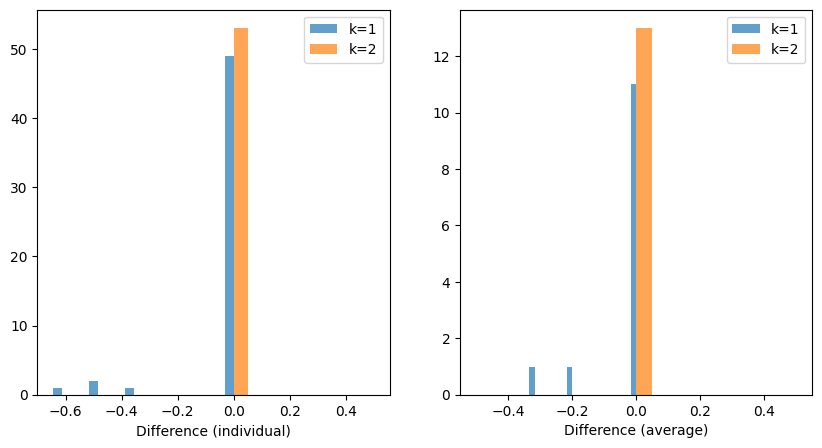

In [125]:
rnd = np.random.RandomState(SEED)
experiment_and_plot(6, rnd=rnd)

In [126]:
experiment_and_plot(8, rnd=rnd)

 10%|█         | 2/20 [00:17<02:34,  8.57s/it]


KeyboardInterrupt: 

In [13]:
# diffs = []
# for i in range(1000):
#     S = get_random_system(NUM_VARS, bool, seed=SEED)
#     T = rerand_system(S, seed=SEED+1)
#     M = S.induced_scm()
#     N = T.induced_scm()
#     vars = list(M.U) + list(M.V)
#     for var in vars:
#         locals()[var] = sp.symbols(var)
#     F = QFFOFormulaFailureSet(eval(get_rand_prop(vars, num_syms=1)))

#     for u_vals in all_combs_b(len(M.U)):
#         u = dict(zip([str(u) for u in M.U], u_vals))
#         state_m, _ = M.get_state(u)
#         state_n, _ = N.get_state(u)
#         if F.contains(state_m) or not F.contains(state_n):
#             # print('Specification already failed or implementation not failed or both!')
#             continue
#         print(k)
#         for k in range(1, 3):
#             k_leg = k_leg_liab(T, S, u, F, k=k)
#             shapley = shapley_liab(T, S, u, F, k=k)
#             for var in k_leg:
#                 if var in shapley:
#                     diffs.append(k_leg[var] - shapley[var])
#                 else:
#                     print(f'Warning: {var} not found in Shapley liability')
#         print()
    
# #############
# ## Current problem: generating a context that M[u] \notin F but N[u] \in F
# ## Solution: Use an SMT solver
# #############